# Система распознавания дорожных знаков на датасете RTSD

## Обогащение датасета знаками из датасетов:
- German Traffic Sign Recognition Benchmark (GTSRB);
- BelgiumTS Dataset;
- Chinese Traffic Signs.

In [262]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

In [263]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
#import fiftyone as fo
#import time
#import torch
#import torch.nn as nn
#import torchvision
#from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from torchvision.models import resnet152
#from sklearn import metrics
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

#import cv2

### Обучающий датасет RTSD

Подготовка обучающего датасета RTSD

In [264]:
# Маппинг кодов знаков на названия знаков
labels_names_map = {}
labels_names_map['1_1'] = 'Железнодорожный переезд со шлагбаумом'
labels_names_map['1_2'] = 'Железнодорожный переезд без шлагбаума'
labels_names_map['1_5'] = 'Пересечение с трамвайной линией'
labels_names_map['1_6'] = 'Пересечение равнозначных дорог'
labels_names_map['1_7'] = 'Пересечение с круговым движением'
labels_names_map['1_8'] = 'Светофорное регулирование'
labels_names_map['1_10'] = 'Выезд на набережную'
labels_names_map['1_11'] = 'Опасный поворот (направо)'
labels_names_map['1_11_1'] = 'Опасный поворот (налево)'
labels_names_map['1_12'] = 'Опасные повороты (первый направо)'
labels_names_map['1_12_2'] = 'Опасные повороты (первый налево)'
labels_names_map['1_13'] = 'Крутой спуск'
labels_names_map['1_14'] = 'Крутой подъём'
labels_names_map['1_15'] = 'Скользкая дорога'
labels_names_map['1_16'] = 'Неровная дорога'
labels_names_map['1_17'] = 'Искусственная неровность'
labels_names_map['1_18'] = 'Выброс гравия'
labels_names_map['1_19'] = 'Опасная обочина'
labels_names_map['1_20'] = 'Сужение дороги (с обеих сторон)'
labels_names_map['1_20_2'] = 'Сужение дороги (с правой стороны)'
labels_names_map['1_20_3'] = 'Сужение дороги (с левой стороны)'
labels_names_map['1_21'] = 'Двустороннее движение'
labels_names_map['1_22'] = 'Пешеходный переход'
labels_names_map['1_23'] = 'Дети'
labels_names_map['1_25'] = 'Дорожные работы'
labels_names_map['1_26'] = 'Перегон скота'
labels_names_map['1_27'] = 'Дикие животные'
labels_names_map['1_30'] = 'Низколетящие саолёты'
labels_names_map['1_31'] = 'Тоннель'
labels_names_map['1_33'] = 'Прочие опасности'
labels_names_map['2_1'] = 'Главная дорога'
labels_names_map['2_2'] = 'Конец главной дороги'
labels_names_map['2_3'] = 'Пересечение со второстепенной дорогой'
labels_names_map['2_3_2'] = 'Примыкание второстепенной дороги (справа)'
labels_names_map['2_3_3'] = 'Примыкание второстепенной дороги (слева)'
labels_names_map['2_3_4'] = 'Примыкание второстепенной дороги (справа)'
labels_names_map['2_3_5'] = 'Примыкание второстепенной дороги (слева)'
labels_names_map['2_3_6'] = 'Примыкание второстепенной дороги (справа)'
labels_names_map['2_4'] = 'Уступите дорогу'
labels_names_map['2_5'] = 'Движение без остановки запрещено'
labels_names_map['2_6'] = 'Преимущество встречного движения'
labels_names_map['2_7'] = 'Преимущество перед встречным движением'
labels_names_map['3_1'] = 'Въезд запрещён'
labels_names_map['3_2'] = 'Движение запрещено'
labels_names_map['3_4'] = 'Движение грузовых автомобилей запрещено (более указанной массы)'
labels_names_map['3_4_1'] = 'Движение грузовых автомобилей запрещено (более 3,5 т)'
labels_names_map['3_6'] = 'Движение тракторов запрещено'
labels_names_map['3_10'] = 'Движение пешеходов запрещено'
labels_names_map['3_11'] = 'Ограничение массы'
labels_names_map['3_12'] = 'Ограничение массы, приходящейся на ось транспортного средства'
labels_names_map['3_13'] = 'Ограничение высоты'
labels_names_map['3_14'] = 'Ограничение ширины'
labels_names_map['3_16'] = 'Ограничение минимальной дистанции'
labels_names_map['3_18'] = 'Поворот направо запрещён'
labels_names_map['3_18_2'] = 'Поворот налево запрещён'
labels_names_map['3_19'] = 'Разворот запрещён'
labels_names_map['3_20'] = 'Обгон запрещён'
labels_names_map['3_21'] = 'Конец зоны запрещения обгона'
labels_names_map['3_24'] = 'Ограничение максимальной скорости'
labels_names_map['3_25'] = 'Конец зоны ограничения максимальной скорости'
labels_names_map['3_27'] = 'Остановка запрещена'
labels_names_map['3_28'] = 'Стоянка запрещена'
labels_names_map['3_29'] = 'Стоянка запрещена по нечётным числам месяца'
labels_names_map['3_30'] = 'Стоянка запрещена по чётным числам месяца'
labels_names_map['3_31'] = 'Конец зоны всех ограничений'
labels_names_map['3_32'] = 'Движение транспортных средств с опасными грузами запрещено'
labels_names_map['3_33'] = 'Движение транспортных средств с взрывчатыми и легковоспламеняющимися грузами запрещено'
labels_names_map['4_1_1'] = 'Движение прямо'
labels_names_map['4_1_2'] = 'Движение направо'
labels_names_map['4_1_2_1'] = 'Движение направо (прямая стрелка)'
labels_names_map['4_1_2_2'] = 'Движение налево (прямая стрелка)'
labels_names_map['4_1_3'] = 'Движение налево'
labels_names_map['4_1_4'] = 'Движение прямо или направо'
labels_names_map['4_1_5'] = 'Движение прямо или налево'
labels_names_map['4_1_6'] = 'Движение направо или налево'
labels_names_map['4_2_1'] = 'Объезд препятствия справа'
labels_names_map['4_2_2'] = 'Объезд препятствия слева'
labels_names_map['4_2_3'] = 'Объезд препятствия справа или слева'
labels_names_map['4_3'] = 'Круговое движение'
labels_names_map['4_5'] = 'Пешеходная дорожка'
labels_names_map['4_8_2'] = 'Направление движения транспортных средств с опасными грузами (направо)'
labels_names_map['4_8_3'] = 'Направление движения транспортных средств с опасными грузами (налево)'
labels_names_map['5_3'] = 'Дорога для автомобилей'
labels_names_map['5_4'] = 'Конец дороги для автомобилей'
labels_names_map['5_5'] = 'Дорога с односторонним движением'
labels_names_map['5_6'] = 'Конец дороги с односторонним движением'
labels_names_map['5_7_1'] = 'Выезд на дорогу с односторонним движением (направо)'
labels_names_map['5_7_2'] = 'Выезд на дорогу с односторонним движением (налево)'
labels_names_map['5_8'] = 'Реверсивное движение'
labels_names_map['5_11'] = 'Дорога с полосой для маршрутных транспортных средств'
labels_names_map['5_12'] = 'Конец дороги с полосой для маршрутных транспортных средств'
labels_names_map['5_14'] = 'Полоса для маршрутных транспортных средств'
labels_names_map['5_15_1'] = 'Направления движения по полосам'
labels_names_map['5_15_2'] = 'Направления движения по полосе'
labels_names_map['5_15_2_2'] = 'Направления движения по полосе (в 2 полосы)'
labels_names_map['5_15_3'] = 'Начало полосы'
labels_names_map['5_15_5'] = 'Конец полосы'
labels_names_map['5_15_7'] = 'Направление движения по полосе'
labels_names_map['5_16'] = 'Место остановки автобуса и (или) троллейбуса'
labels_names_map['5_17'] = 'Место остановки трамвая'
labels_names_map['5_18'] = 'Место стоянки легковых такси'
labels_names_map['5_19_1'] = 'Пешеходный переход'
labels_names_map['5_20'] = 'Искусственная неровность'
labels_names_map['5_21'] = 'Жилая зона'
labels_names_map['5_22'] = 'Конец жилой зоны'
labels_names_map['6_2'] = 'Рекомендуемая скорость'
labels_names_map['6_3_1'] = 'Место для разворота'
labels_names_map['6_4'] = 'Парковка (парковочное место)'
labels_names_map['6_6'] = 'Подземный пешеходный переход'
labels_names_map['6_7'] = 'Надземный пешеходный переход'
labels_names_map['6_8_1'] = 'Тупик (прямо)'
labels_names_map['6_8_2'] = 'Тупик (направо)'
labels_names_map['6_8_3'] = 'Тупик (налево)'
labels_names_map['6_15_1'] = 'Направление движения для грузовых автомобилей (прямо)'
labels_names_map['6_15_2'] = 'Направление движения для грузовых автомобилей (направо)'
labels_names_map['6_15_3'] = 'Направление движения для грузовых автомобилей (налево)'
labels_names_map['6_16'] = 'Стоп-линия'
labels_names_map['7_1'] = 'Пункт первой медицинской помощи'
labels_names_map['7_2'] = 'Больница'
labels_names_map['7_3'] = 'Автозаправочная станция'
labels_names_map['7_4'] = 'Техническое обслуживание автомобилей'
labels_names_map['7_5'] = 'Мойка автомобилей'
labels_names_map['7_6'] = 'Телефон'
labels_names_map['7_7'] = 'Пункт питания'
labels_names_map['7_11'] = 'Место отдыха'
labels_names_map['7_12'] = 'Пост ДПС'
labels_names_map['7_14'] = 'Пункт транспортного контроля'
labels_names_map['7_15'] = 'Зона приёма радиостанции, передающей информацию о дорожном движении'
labels_names_map['7_18'] = 'Туалет'
labels_names_map['8_1_1'] = 'Расстояние до объекта'
labels_names_map['8_1_3'] = 'Расстояние до объекта (в стороне от дороги справа)'
labels_names_map['8_1_4'] = 'Расстояние до объекта (в стороне от дороги слева)'
labels_names_map['8_2_1'] = 'Зона действия (протяженность)'
labels_names_map['8_2_2'] = 'Зона действия'
labels_names_map['8_2_3'] = 'Зона действия (конец зоны действия)'
labels_names_map['8_2_4'] = 'Зона действия (нахождение в зоне действия)'
labels_names_map['8_3_1'] = 'Направления действия (направо)'
labels_names_map['8_3_2'] = 'Направления действия (налево)'
labels_names_map['8_3_3'] = 'Направления действия (направо и налево)'
labels_names_map['8_4_1'] = 'Вид транспортного средства (грузовой автомобиль более 3,5 т)'
labels_names_map['8_4_3'] = 'Вид транспортного средства (легковой автомобиль)'
labels_names_map['8_4_4'] = 'Вид транспортного средства (автобус)'
labels_names_map['8_5_2'] = 'Рабочие дни'
labels_names_map['8_5_4'] = 'Время действия'
labels_names_map['8_6_2'] = 'Способ постановки транспортного средства на стоянку (в заездом на обочину)'
labels_names_map['8_6_4'] = 'Способ постановки транспортного средства на стоянку (перпендикулярно обочине)'
labels_names_map['8_8'] = 'Платные услуги'
labels_names_map['8_13'] = 'Направление главной дороги'
labels_names_map['8_13_1'] = 'Направление главной дороги (кольцо)'
labels_names_map['8_14'] = 'Полоса движения'
labels_names_map['8_15'] = 'Слепые пешеходы'
labels_names_map['8_16'] = 'Влажное покрытие'
labels_names_map['8_17'] = 'Инвалиды'
labels_names_map['8_18'] = 'Кроме инвалидов'
labels_names_map['8_23'] = 'Фотовидеофиксация'

#with open(os.path.join(dataset_path, 'labels_names_map.json'), 'w') as f:
#    json.dump(labels_names_map, f)#ensure_ascii=False, indent=4)
#f.close()

labels_names_map

{'1_1': 'Железнодорожный переезд со шлагбаумом',
 '1_2': 'Железнодорожный переезд без шлагбаума',
 '1_5': 'Пересечение с трамвайной линией',
 '1_6': 'Пересечение равнозначных дорог',
 '1_7': 'Пересечение с круговым движением',
 '1_8': 'Светофорное регулирование',
 '1_10': 'Выезд на набережную',
 '1_11': 'Опасный поворот (направо)',
 '1_11_1': 'Опасный поворот (налево)',
 '1_12': 'Опасные повороты (первый направо)',
 '1_12_2': 'Опасные повороты (первый налево)',
 '1_13': 'Крутой спуск',
 '1_14': 'Крутой подъём',
 '1_15': 'Скользкая дорога',
 '1_16': 'Неровная дорога',
 '1_17': 'Искусственная неровность',
 '1_18': 'Выброс гравия',
 '1_19': 'Опасная обочина',
 '1_20': 'Сужение дороги (с обеих сторон)',
 '1_20_2': 'Сужение дороги (с правой стороны)',
 '1_20_3': 'Сужение дороги (с левой стороны)',
 '1_21': 'Двустороннее движение',
 '1_22': 'Пешеходный переход',
 '1_23': 'Дети',
 '1_25': 'Дорожные работы',
 '1_26': 'Перегон скота',
 '1_27': 'Дикие животные',
 '1_30': 'Низколетящие саолёты',


In [265]:
# Расшифровки ID категорий
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()

# Аннотация обучающей выборки RTSD
with open(os.path.join(dataset_path, 'train_anno.json'), 'r') as read_file:
    RTSD_train_anno = json.load(read_file)
read_file.close()

# Преобразование аннотаций к формату для классификации
RTSD_train = pd.DataFrame(RTSD_train_anno.get('annotations'))
RTSD_train_images = pd.DataFrame(RTSD_train_anno.get('images'))
RTSD_train = RTSD_train.merge(RTSD_train_images, left_on='image_id', right_on='id')[['file_name','width','height','bbox','category_id']]
# Приведение bbox из формата COCO (x1, y1, w, h) к виду (x1, y1, x2, y2)
RTSD_train['bbox'] = RTSD_train['bbox'].apply (lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]])
# Добавим для визуалиции labels
RTSD_train = RTSD_train.merge(pd.DataFrame([label_map]).T.reset_index().set_index(0), left_on='category_id', right_index=True)
RTSD_train.rename(columns={'index':'sign'}, inplace=True)
# Добавим вспомогательную колонку с источником изображения (датасет)
RTSD_train.insert(1, 'source', 'RTSD_train')
# Добавим столбец с наименованием знака
RTSD_train = RTSD_train.merge(pd.DataFrame([labels_names_map]).T, left_on='sign', right_index=True)
RTSD_train.rename(columns={0:'sign_name'}, inplace=True)
RTSD_train

,file_name,source,width,height,bbox,category_id,sign,sign_name
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,RTSD_train,1280,720,"[649, 376, 667, 394]",1,2_1,Главная дорога
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,RTSD_train,1280,720,"[671, 356, 691, 377]",1,2_1,Главная дорога
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,RTSD_train,1280,720,"[711, 332, 738, 358]",1,2_1,Главная дорога
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,RTSD_train,1280,720,"[764, 290, 801, 326]",1,2_1,Главная дорога
5,rtsd-frames/autosave01_02_2012_09_13_37.jpg,RTSD_train,1280,720,"[876, 200, 932, 257]",1,2_1,Главная дорога
...,...,...,...,...,...,...,...,...
93566,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg,RTSD_train,1280,720,"[767, 306, 806, 366]",154,7_14,Пункт транспортного контроля
93567,rtsd-frames/autosave24_10_2013_11_23_20_1.jpg,RTSD_train,1280,720,"[1143, 101, 1255, 252]",154,7_14,Пункт транспортного контроля
93720,rtsd-frames/autosave24_10_2013_11_29_00_0.jpg,RTSD_train,1280,720,"[762, 367, 798, 384]",155,8_23,Фотовидеофиксация
93723,rtsd-frames/autosave24_10_2013_11_29_00_1.jpg,RTSD_train,1280,720,"[878, 346, 934, 372]",155,8_23,Фотовидеофиксация


Визуализация исходного обучающего датасета

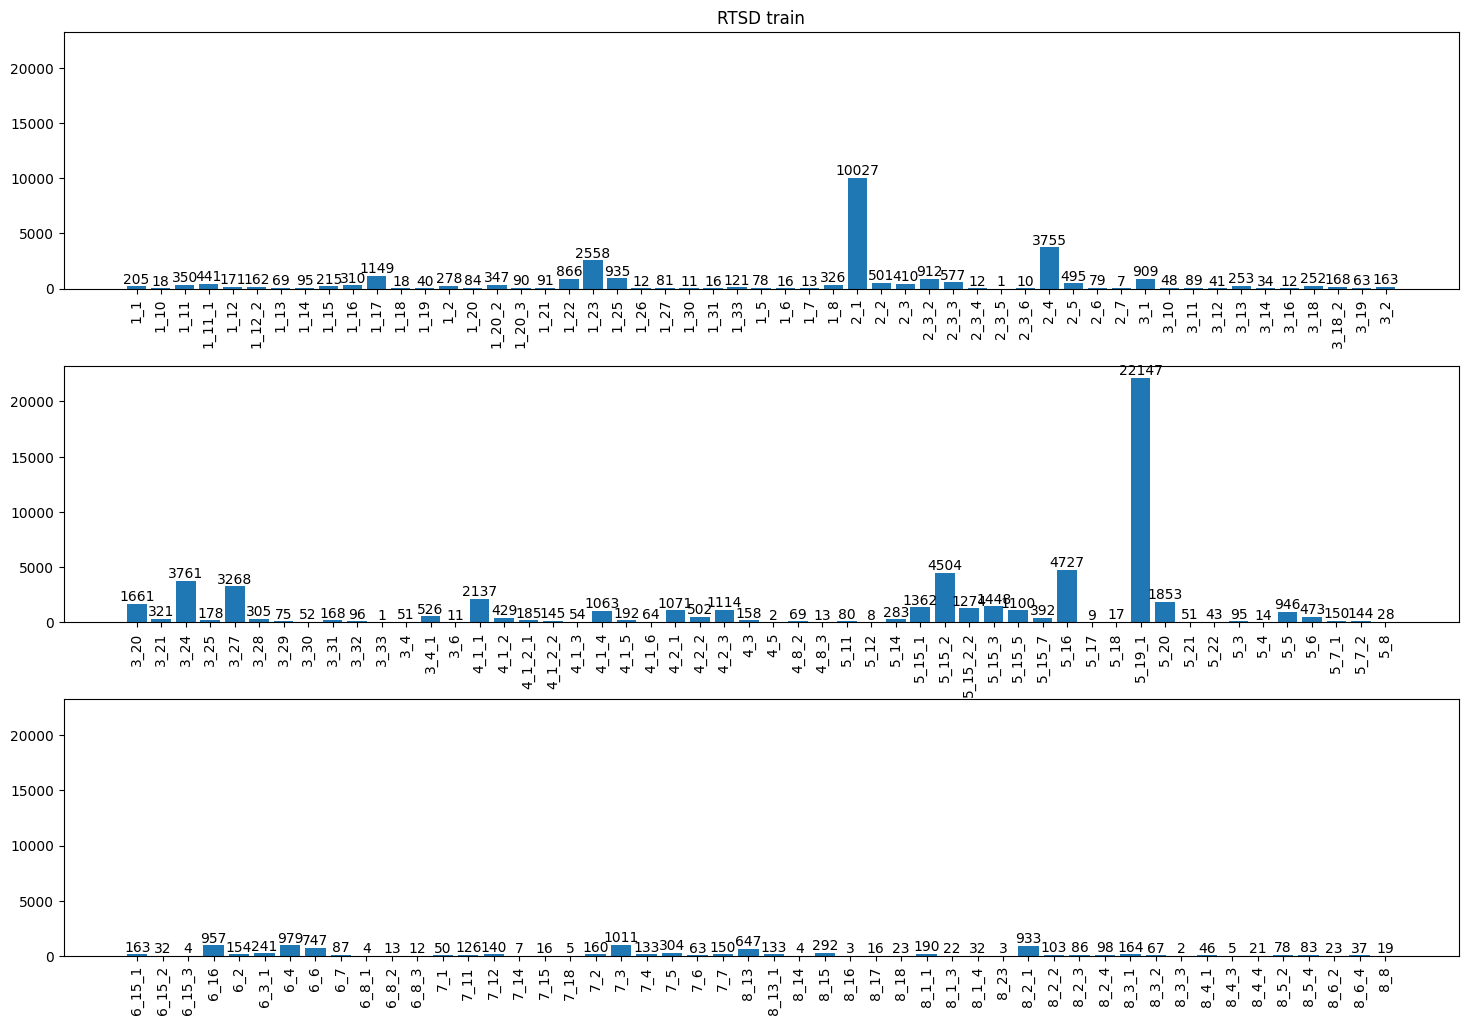

In [266]:
RTSD_train_distribution = RTSD_train['sign'].value_counts().sort_index()
RTSD_train_distribution.name = 'count'
plot1 = RTSD_train_distribution[:53].copy()
plot2 = RTSD_train_distribution[53:105].copy()
plot3 = RTSD_train_distribution[105:].copy()
fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()
bar1 = ax1.bar(plot1.index, plot1.values)
bar2 = ax2.bar(plot2.index, plot2.values)
bar3 = ax3.bar(plot3.index, plot3.values)
ax1.set_xticks(plot1.index, plot1.index, rotation=90)
ax2.set_xticks(plot2.index, plot2.index, rotation=90)
ax3.set_xticks(plot3.index, plot3.index, rotation=90)
ax1.bar_label(bar1)
ax2.bar_label(bar2)
ax3.bar_label(bar3)
ax1.set_title('RTSD train')
fig.set_size_inches(18,12)
plt.subplots_adjust(hspace=0.3)
plt.show()

### Датасет German Traffic Sign Recognition Benchmark (GTSRB)

In [9]:
# Мой маппинг категорий German Traffic Sign Recognition Benchmark (GTSRB) на Российские знаки (которые есть в RTSD)
GTSRB_to_RTSD_labels = {}
GTSRB_to_RTSD_labels[0] = '3_24'
GTSRB_to_RTSD_labels[1] = '3_24'
GTSRB_to_RTSD_labels[2] = '3_24'
GTSRB_to_RTSD_labels[3] = '3_24'
GTSRB_to_RTSD_labels[4] = '3_24'
GTSRB_to_RTSD_labels[5] = '3_24'
GTSRB_to_RTSD_labels[6] = '3_25'
GTSRB_to_RTSD_labels[7] = '3_24'
GTSRB_to_RTSD_labels[8] = '3_24'             
GTSRB_to_RTSD_labels[9] = '3_20'
GTSRB_to_RTSD_labels[11] = '2_3'
GTSRB_to_RTSD_labels[12] = '2_1'
GTSRB_to_RTSD_labels[13] = '2_4'
GTSRB_to_RTSD_labels[14] = '2_5'
GTSRB_to_RTSD_labels[15] = '3_2'
GTSRB_to_RTSD_labels[16] = '3_4_1'     
GTSRB_to_RTSD_labels[17] = '3_1'
GTSRB_to_RTSD_labels[18] = '1_33'
GTSRB_to_RTSD_labels[19] = '1_11_1'
GTSRB_to_RTSD_labels[20] = '1_11'
GTSRB_to_RTSD_labels[22] = '1_16'
GTSRB_to_RTSD_labels[23] = '1_15'
GTSRB_to_RTSD_labels[25] = '1_25'
GTSRB_to_RTSD_labels[26] = '1_8'
GTSRB_to_RTSD_labels[27] = '1_22'
GTSRB_to_RTSD_labels[28] = '1_23'   
GTSRB_to_RTSD_labels[31] = '1_27'              
GTSRB_to_RTSD_labels[32] = '3_31'
GTSRB_to_RTSD_labels[33] = '4_1_2'
GTSRB_to_RTSD_labels[34] = '4_1_3'
GTSRB_to_RTSD_labels[35] = '4_1_1'
GTSRB_to_RTSD_labels[36] = '4_1_4'
GTSRB_to_RTSD_labels[37] = '4_1_5'
GTSRB_to_RTSD_labels[38] = '4_2_1'  
GTSRB_to_RTSD_labels[39] = '4_2_2'
GTSRB_to_RTSD_labels[40] = '4_3'
GTSRB_to_RTSD_labels[41] = '3_21'

#with open(os.path.join(dataset_path, 'GTSRB_to_RTSD_labels_map.json'), 'w') as f:
#    json.dump(GTSRB_to_RTSD_labels, f)#ensure_ascii=False, indent=4)
#f.close()

GTSRB_to_RTSD_labels

{0: '3_24',
 1: '3_24',
 2: '3_24',
 3: '3_24',
 4: '3_24',
 5: '3_24',
 6: '3_25',
 7: '3_24',
 8: '3_24',
 9: '3_20',
 11: '2_3',
 12: '2_1',
 13: '2_4',
 14: '2_5',
 15: '3_2',
 16: '3_4_1',
 17: '3_1',
 18: '1_33',
 19: '1_11_1',
 20: '1_11',
 22: '1_16',
 23: '1_15',
 25: '1_25',
 26: '1_8',
 27: '1_22',
 28: '1_23',
 31: '1_27',
 32: '3_31',
 33: '4_1_2',
 34: '4_1_3',
 35: '4_1_1',
 36: '4_1_4',
 37: '4_1_5',
 38: '4_2_1',
 39: '4_2_2',
 40: '4_3',
 41: '3_21'}

In [267]:
# Обучающая выборка
GTSRB_train = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Train.csv'))
GTSRB_train.insert(0, 'source', 'GTSRB_train')
# Валидационная выборка
GTSRB_test = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Test.csv'))
GTSRB_test.insert(0, 'source', 'GTSRB_test')
# Объединение обучающей и тестовой выборок GTSRB (валидация будет проводиться на тестовой выборке RTSD)

GTSRB_full = pd.concat((GTSRB_train, GTSRB_test))
GTSRB_full.reset_index(inplace=True)
del GTSRB_full['index']

# Приведение датасеты к виду скорректированного RTSD
# Корректировка пути к изображению
GTSRB_full.insert(0, 'file_name', '')
GTSRB_full['file_name'] = GTSRB_full['Path'].apply(lambda x: 'GTSRB/' + x)
del GTSRB_full['Path']
# Столбец bbox
GTSRB_full.insert(2, 'bbox', '')
for i in range(len(GTSRB_full)):
    x1 = int(GTSRB_full.loc[i, 'Roi.X1'])
    y1 = int(GTSRB_full.loc[i, 'Roi.Y1'])
    x2 = int(GTSRB_full.loc[i, 'Roi.X2'])
    y2 = int(GTSRB_full.loc[i, 'Roi.Y2'])
    bbox = [x1, y1, x2, y2]
    GTSRB_full['bbox'].iloc[i] = bbox.copy()

del GTSRB_full['Roi.X1']
del GTSRB_full['Roi.Y1']
del GTSRB_full['Roi.X2']
del GTSRB_full['Roi.Y2']
GTSRB_full.rename(columns={'Width': 'width', 'Height': 'height'}, inplace=True)

# Добавим российские лейблы и категории в датасет
# Знаки, которые не соотносятся с RTSD удаляются
GTSRB_full = GTSRB_full.merge(pd.DataFrame([GTSRB_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
GTSRB_full.rename(columns={0:'sign'}, inplace=True)
# Добавим классы знаков RTSD
GTSRB_full = GTSRB_full.merge(pd.DataFrame([label_map]).T, left_on='sign', right_index=True)
GTSRB_full.rename(columns={0:'category_id'}, inplace=True)
# Добавим столбец с наименованием знака
GTSRB_full = GTSRB_full.merge(pd.DataFrame([labels_names_map]).T, left_on='sign', right_index=True)
GTSRB_full.rename(columns={0:'sign_name'}, inplace=True)
GTSRB_full.reset_index(inplace=True)
del GTSRB_full['index']
GTSRB_full = GTSRB_full[['file_name', 'source', 'width', 'height', 'bbox', 'ClassId', 'category_id', 'sign', 'sign_name']]
#del GTSRB_full['ClassId']
GTSRB_full

C:\Users\User\AppData\Local\Temp\ipykernel_1688\2214852796.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GTSRB_full['bbox'].iloc[i] = bbox.copy()


,file_name,source,width,height,bbox,ClassId,category_id,sign,sign_name
0,GTSRB/Train/20/00020_00000_00000.png,GTSRB_train,27,26,"[5, 5, 22, 20]",20,62,1_11,Опасный поворот (направо)
1,GTSRB/Train/20/00020_00000_00001.png,GTSRB_train,28,27,"[5, 6, 23, 22]",20,62,1_11,Опасный поворот (направо)
2,GTSRB/Train/20/00020_00000_00002.png,GTSRB_train,29,26,"[6, 5, 24, 21]",20,62,1_11,Опасный поворот (направо)
3,GTSRB/Train/20/00020_00000_00003.png,GTSRB_train,28,27,"[5, 6, 23, 22]",20,62,1_11,Опасный поворот (направо)
4,GTSRB/Train/20/00020_00000_00004.png,GTSRB_train,28,26,"[5, 5, 23, 21]",20,62,1_11,Опасный поворот (направо)
...,...,...,...,...,...,...,...,...,...
47094,GTSRB/Test/11497.png,GTSRB_test,38,38,"[5, 5, 33, 33]",41,102,3_21,Конец зоны запрещения обгона
47095,GTSRB/Test/11889.png,GTSRB_test,42,43,"[5, 6, 37, 38]",41,102,3_21,Конец зоны запрещения обгона
47096,GTSRB/Test/12057.png,GTSRB_test,62,62,"[6, 6, 57, 57]",41,102,3_21,Конец зоны запрещения обгона
47097,GTSRB/Test/12407.png,GTSRB_test,37,37,"[6, 6, 32, 32]",41,102,3_21,Конец зоны запрещения обгона


Примечания:
- Знак категории 11 - Пересечение со второстепенной дорогой (немного отличается)    '2_3';
- Знак категории 28 - Осторожно дети (немного отличается)                           '1_23'   

In [307]:
# Перебор категорий и проверка что они соответствуют
class_num = 0

'Дети'

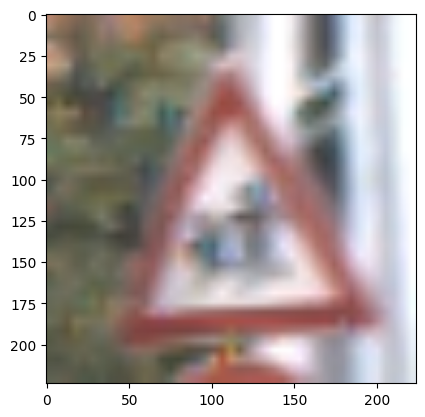

In [349]:
unique_cat = list(GTSRB_full.ClassId.unique())
class_id = unique_cat[class_num]
index = 14
df_temp = GTSRB_full[GTSRB_full['ClassId'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'file_name']
class_num+=1
display(df_temp.loc[index, 'sign_name'])
img = Image.open(os.path.join(dataset_path, img_name))
transform = transforms.Compose([transforms.Resize((224,224))])   
img = transform(img)
fig, a = plt.subplots(1,1)
a.imshow(img)

In [18]:
# Распределение частоты появления знаков в RTSD_train
RTSD_train_distribution = pd.DataFrame(RTSD_train['sign'].value_counts().sort_index())
# Распределение частоты появления знаков в GTSRB_full
GTSRB_full_distribution = pd.DataFrame(GTSRB_full['sign'].value_counts())
# Результирующий датасет
counts_signs_all = pd.merge(RTSD_train_distribution, GTSRB_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all.rename(columns={'sign_x': 'RTSD_train', 'sign_y': 'GTSRB_full'},inplace=True)
# Заменим пропуски нулями
counts_signs_all = counts_signs_all.fillna(0)
counts_signs_all['GTSRB_full'] = counts_signs_all['GTSRB_full'] .astype(int)
counts_signs_all

,RTSD_train,GTSRB_full
1_1,205,0
1_10,18,0
1_11,350,450
1_11_1,441,270
1_12,171,0
...,...,...
8_5_2,78,0
8_5_4,83,0
8_6_2,23,0
8_6_4,37,0


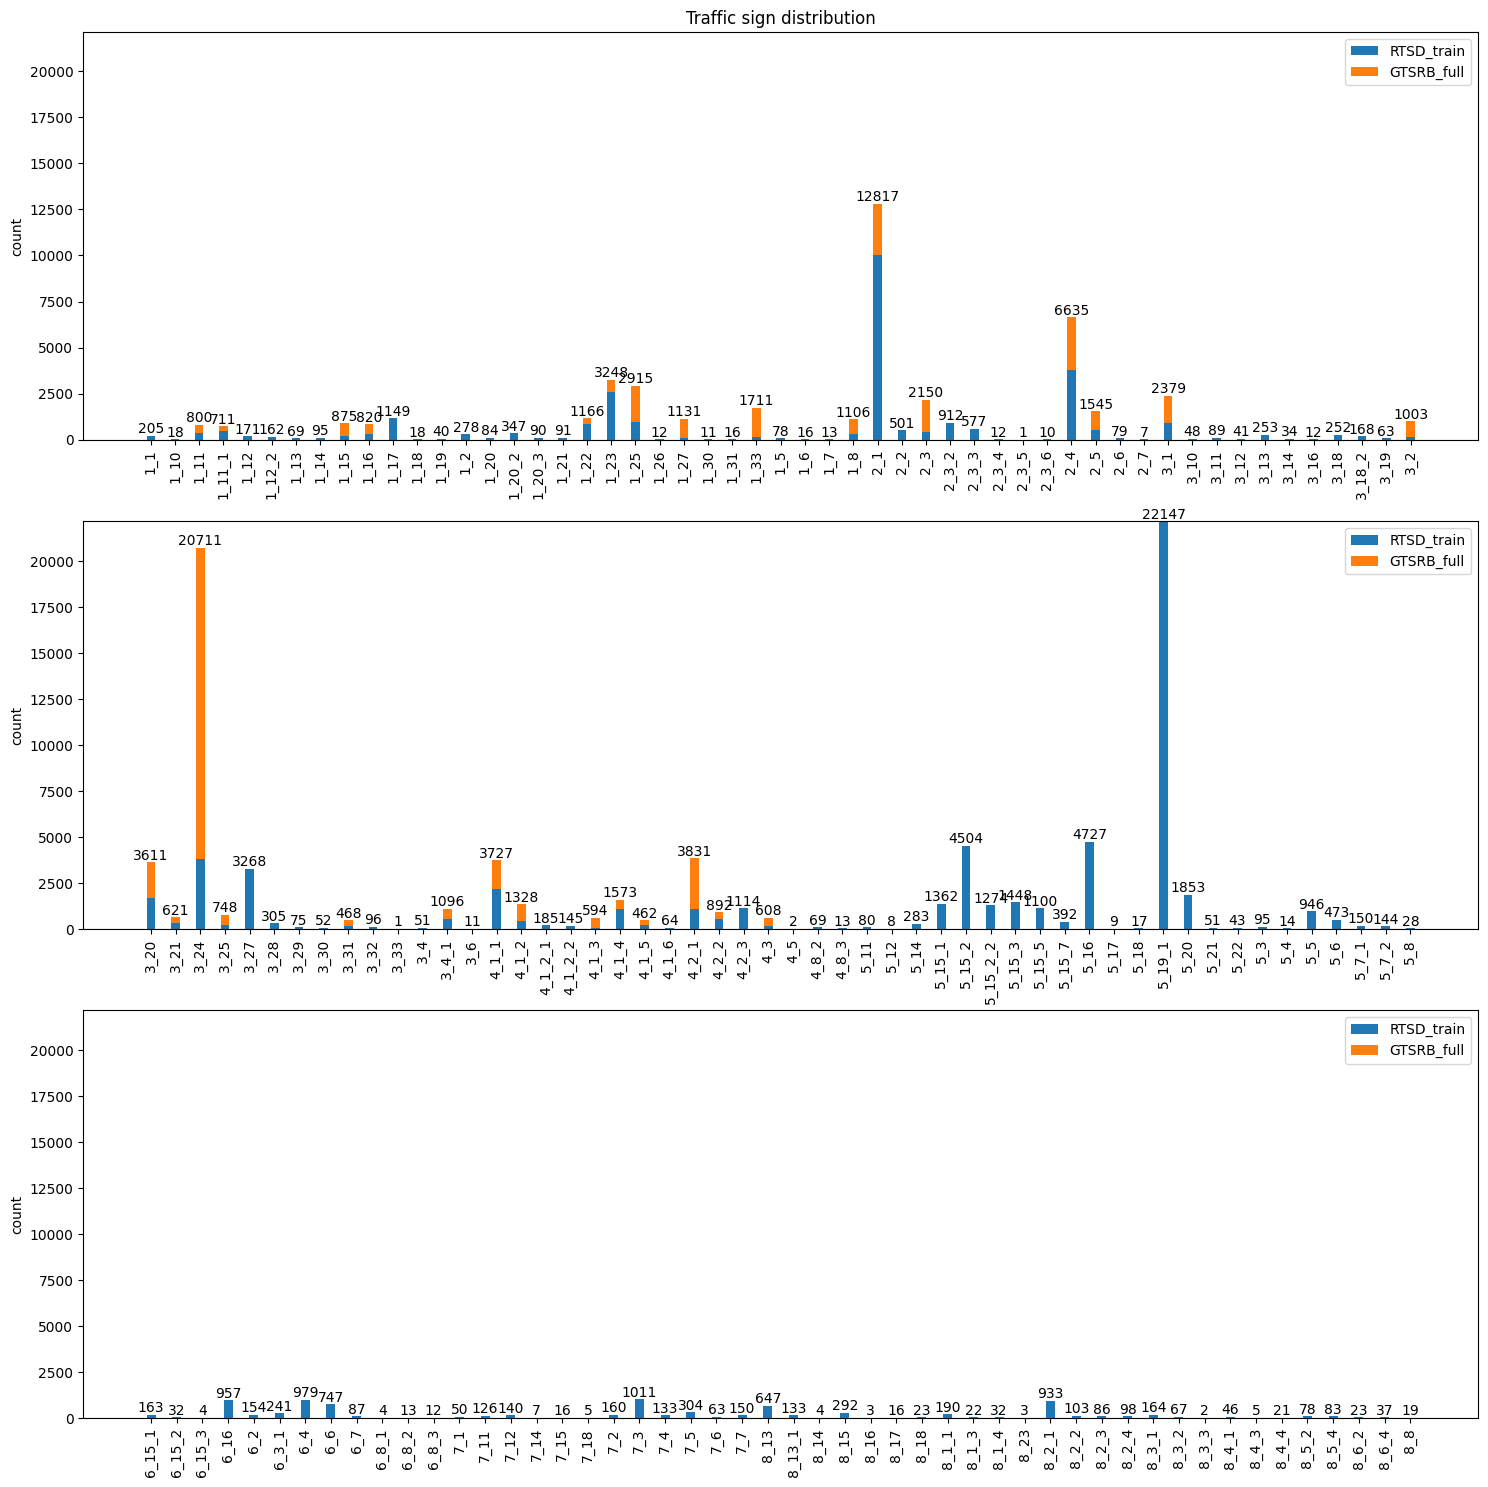

In [19]:
x1 = counts_signs_all.index[:53]   # the x locations for the groups
y1_1 = counts_signs_all.RTSD_train[:53]
y1_2 = counts_signs_all.GTSRB_full[:53]

x2 = counts_signs_all.index[53:105]   # the x locations for the groups
y2_1 = counts_signs_all.RTSD_train[53:105]
y2_2 = counts_signs_all.GTSRB_full[53:105]

x3 = counts_signs_all.index[105:]   # the x locations for the groups
y3_1 = counts_signs_all.RTSD_train[105:]
y3_2 = counts_signs_all.GTSRB_full[105:]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()

p1_1 = ax1.bar(x1 , y1_1, width, label='RTSD_train')
p1_2 = ax1.bar(x1 , y1_2, width, bottom=y1_1, label='GTSRB_full')
ax1.axhline(0, color='grey', linewidth=0.8)
ax1.set_ylabel('count')
ax1.set_title('Traffic sign distribution')
ax1.set_xticks(x1, x1, rotation=90)
ax1.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax1.bar_label(p1_1, label_type='center')
#ax1.bar_label(p1_2, label_type='center')
ax1.bar_label(p1_2)

p2_1 = ax2.bar(x2 , y2_1, width, label='RTSD_train')
p2_2 = ax2.bar(x2 , y2_2, width, bottom=y2_1, label='GTSRB_full')
ax2.axhline(0, color='grey', linewidth=0.8)
ax2.set_ylabel('count')
ax2.set_xticks(x2, x2, rotation=90)
ax2.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax2.bar_label(p2_1, label_type='center')
#ax2.bar_label(p2_2, label_type='center')
ax2.bar_label(p2_2)

p3_1 = ax3.bar(x3, y3_1, width, label='RTSD_train')
p3_2 = ax3.bar(x3, y3_2, width, bottom=y3_1, label='GTSRB_full')
ax3.axhline(0, color='grey', linewidth=0.8)
ax3.set_ylabel('count')
ax3.set_xticks(x3, x3, rotation=90)
ax3.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax3.bar_label(p3_1, label_type='center')
#ax3.bar_label(p3_2, label_type='center')
ax3.bar_label(p3_2)

fig.set_size_inches(18,18)
plt.show()

### Датасет BelgiumTS Dataset

In [350]:
# Мой маппинг категорий BelgiumTSC на Российские знаки (которые есть в RTSD)
BelgiumTSC_to_RTSD_labels = {}

BelgiumTSC_to_RTSD_labels[0] = '1_16'                      
BelgiumTSC_to_RTSD_labels[1] = '1_17'
BelgiumTSC_to_RTSD_labels[2] = '1_15'
BelgiumTSC_to_RTSD_labels[3] = '1_11_1'
BelgiumTSC_to_RTSD_labels[4] = '1_11'    
BelgiumTSC_to_RTSD_labels[5] = '1_12_2'
BelgiumTSC_to_RTSD_labels[6] = '1_12'
BelgiumTSC_to_RTSD_labels[7] = '1_23'
BelgiumTSC_to_RTSD_labels[9] = '1_26'
BelgiumTSC_to_RTSD_labels[10] = '1_25'
BelgiumTSC_to_RTSD_labels[11] = '1_8'
BelgiumTSC_to_RTSD_labels[12] = '1_1'
BelgiumTSC_to_RTSD_labels[13] = '1_33'
BelgiumTSC_to_RTSD_labels[14] = '1_20'
BelgiumTSC_to_RTSD_labels[15] = '1_20_3'
BelgiumTSC_to_RTSD_labels[16] = '1_20_2'
BelgiumTSC_to_RTSD_labels[18] = '1_6'
BelgiumTSC_to_RTSD_labels[19] = '2_4'
BelgiumTSC_to_RTSD_labels[20] = '2_6'
BelgiumTSC_to_RTSD_labels[21] = '2_5'
BelgiumTSC_to_RTSD_labels[22] = '3_1' 
BelgiumTSC_to_RTSD_labels[24] = '3_11'
BelgiumTSC_to_RTSD_labels[25] = '3_4'
BelgiumTSC_to_RTSD_labels[26] = '3_14'
BelgiumTSC_to_RTSD_labels[27] = '3_13'
BelgiumTSC_to_RTSD_labels[28] = '3_2'
BelgiumTSC_to_RTSD_labels[29] = '3_18_2'
BelgiumTSC_to_RTSD_labels[30] = '3_18'
BelgiumTSC_to_RTSD_labels[31] = '3_20'
BelgiumTSC_to_RTSD_labels[32] = '3_24'
BelgiumTSC_to_RTSD_labels[34] = '4_1_1'
BelgiumTSC_to_RTSD_labels[36] = '4_1_4'
BelgiumTSC_to_RTSD_labels[37] = '4_3'
BelgiumTSC_to_RTSD_labels[40] = '3_28'
BelgiumTSC_to_RTSD_labels[41] = '3_27'
BelgiumTSC_to_RTSD_labels[42] = '3_27'
BelgiumTSC_to_RTSD_labels[43] = '3_27'
BelgiumTSC_to_RTSD_labels[44] = '2_7'
BelgiumTSC_to_RTSD_labels[45] = '6_4'
BelgiumTSC_to_RTSD_labels[46] = '6_4'
BelgiumTSC_to_RTSD_labels[47] = '6_4'
BelgiumTSC_to_RTSD_labels[48] = '6_4'
BelgiumTSC_to_RTSD_labels[49] = '6_4'
BelgiumTSC_to_RTSD_labels[50] = '6_4'
BelgiumTSC_to_RTSD_labels[51] = '5_21'
BelgiumTSC_to_RTSD_labels[52] = '5_22'
BelgiumTSC_to_RTSD_labels[53] = '5_5'
BelgiumTSC_to_RTSD_labels[54] = '6_8_1'
BelgiumTSC_to_RTSD_labels[56] = '5_19_1'
BelgiumTSC_to_RTSD_labels[59] = '5_20'
BelgiumTSC_to_RTSD_labels[60] = '2_2'
BelgiumTSC_to_RTSD_labels[61] = '2_1'

#with open(os.path.join(dataset_path, 'BelgiumTSC_to_RTSD_labels.json'), 'w') as f:
#    json.dump(BelgiumTSC_to_RTSD_labels, f)#ensure_ascii=False, indent=4)
#f.close()

BelgiumTSC_to_RTSD_labels

{0: '1_16',
 1: '1_17',
 2: '1_15',
 3: '1_11_1',
 4: '1_11',
 5: '1_12_2',
 6: '1_12',
 7: '1_23',
 9: '1_26',
 10: '1_25',
 11: '1_8',
 12: '1_1',
 13: '1_33',
 14: '1_20',
 15: '1_20_3',
 16: '1_20_2',
 18: '1_6',
 19: '2_4',
 20: '2_6',
 21: '2_5',
 22: '3_1',
 24: '3_11',
 25: '3_4',
 26: '3_14',
 27: '3_13',
 28: '3_2',
 29: '3_18_2',
 30: '3_18',
 31: '3_20',
 32: '3_24',
 34: '4_1_1',
 36: '4_1_4',
 37: '4_3',
 40: '3_28',
 41: '3_27',
 42: '3_27',
 43: '3_27',
 44: '2_7',
 45: '6_4',
 46: '6_4',
 47: '6_4',
 48: '6_4',
 49: '6_4',
 50: '6_4',
 51: '5_21',
 52: '5_22',
 53: '5_5',
 54: '6_8_1',
 56: '5_19_1',
 59: '5_20',
 60: '2_2',
 61: '2_1'}

Примечания:
- Знак категории 0 - Ухабистая дорога (немного отличается)      '1_16';
- Знак категории 7 - Школьная зона (немного не похоже)          '1_23';
- Знак категории 24 - Ограничение по массе (немного не похоже)  '3_11'
- Знак категории 26 - Ограничение по ширине (немного не похоже) '3_14'
- Знак категории 27 - Ограничение по высоте (немного не похоже) '3_13'
- Знак категории 42 - Парковка запрещена с 1 по 15 число месяца '3_27'
- Знак категории 43 - Парковка запрещена с 15-го                '3_27'
- Знак категории 46 - Парковка, предназначенная для инвалидов   '6_4';
- Знак категории 47 - Парковка, предназначенная для ...         '6_4';
- Знак категории 48 - Парковка, предназначенная для грузовиков  '6_4';
- Знак категории 49 - Парковка, предназначенная для автобусов   '6_4';
- Знак категории 56 - Пешеходный переход (немного не похож)     '5_19_1'.

In [25]:
# Обучающая выборка
BelgiumTSC_train = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Training/Training/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_train = pd.concat((BelgiumTSC_train, df_temp))
BelgiumTSC_train.insert(0, 'source', 'BelgiumTSC_train')

# Валидационная выборка
BelgiumTSC_test = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Testing/Testing/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_test = pd.concat((BelgiumTSC_test, df_temp))
BelgiumTSC_test.insert(0, 'source', 'BelgiumTSC_test')

# Объединение обучающей и тестовой выборок BelgiumTSC (валидация будет проводиться на тестовой выборке RTSD)
BelgiumTSC_full = pd.concat((BelgiumTSC_train, BelgiumTSC_test))
BelgiumTSC_full.reset_index(inplace=True)
del BelgiumTSC_full['index']

# Приведение датасеты к виду скорректированного RTSD
# Корректировка пути к изображению
BelgiumTSC_full.insert(0, 'file_name', '')
BelgiumTSC_full['file_name'] = BelgiumTSC_full['Filename'].apply(lambda x: 'BelgiumTSC/' + x)
del BelgiumTSC_full['Filename']

# Столбец bbox
BelgiumTSC_full.insert(2, 'bbox', '')
for i in range(len(BelgiumTSC_full)):
    x1 = int(BelgiumTSC_full.loc[i, 'Roi.X1'])
    y1 = int(BelgiumTSC_full.loc[i, 'Roi.Y1'])
    x2 = int(BelgiumTSC_full.loc[i, 'Roi.X2'])
    y2 = int(BelgiumTSC_full.loc[i, 'Roi.Y2'])
    bbox = [x1, y1, x2, y2]
    BelgiumTSC_full['bbox'].iloc[i] = bbox.copy()

del BelgiumTSC_full['Roi.X1']
del BelgiumTSC_full['Roi.Y1']
del BelgiumTSC_full['Roi.X2']
del BelgiumTSC_full['Roi.Y2']
BelgiumTSC_full.rename(columns={'Width': 'width', 'Height': 'height'}, inplace=True)

# Добавим российские лейблы и категории в датасет
# Знаки, которые не соотносятся с RTSD удаляются
BelgiumTSC_full = BelgiumTSC_full.merge(pd.DataFrame([BelgiumTSC_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
BelgiumTSC_full.rename(columns={0:'sign'}, inplace=True)
# Добавим классы знаков RTSD
BelgiumTSC_full = BelgiumTSC_full.merge(pd.DataFrame([label_map]).T, left_on='sign', right_index=True)
BelgiumTSC_full.rename(columns={0:'category_id'}, inplace=True)
# Добавим столбец с наименованием знака
BelgiumTSC_full = BelgiumTSC_full.merge(pd.DataFrame([labels_names_map]).T, left_on='sign', right_index=True)
BelgiumTSC_full.rename(columns={0:'sign_name'}, inplace=True)
BelgiumTSC_full.reset_index(inplace=True)
del BelgiumTSC_full['index']
GTSRB_full = GTSRB_full[['file_name', 'source', 'width', 'height', 'bbox', 'ClassId', 'category_id', 'sign', 'sign_name']]
#del BelgiumTSC_full['ClassId']
BelgiumTSC_full

,file_name,source,bbox,width,height,ClassId,sign,category_id,sign_name
0,BelgiumTSC/BelgiumTSC_Training/Training/00000/...,BelgiumTSC_train,"[12, 12, 128, 130]",141,142,0,1_16,38,Неровная дорога
1,BelgiumTSC/BelgiumTSC_Training/Training/00000/...,BelgiumTSC_train,"[10, 10, 109, 113]",120,123,0,1_16,38,Неровная дорога
2,BelgiumTSC/BelgiumTSC_Training/Training/00000/...,BelgiumTSC_train,"[9, 9, 96, 98]",105,107,0,1_16,38,Неровная дорога
3,BelgiumTSC/BelgiumTSC_Training/Training/00000/...,BelgiumTSC_train,"[8, 9, 86, 95]",94,105,0,1_16,38,Неровная дорога
4,BelgiumTSC/BelgiumTSC_Training/Training/00000/...,BelgiumTSC_train,"[11, 12, 117, 127]",128,139,0,1_16,38,Неровная дорога
...,...,...,...,...,...,...,...,...,...
5576,BelgiumTSC/BelgiumTSC_Testing/Testing/00061/00...,BelgiumTSC_test,"[9, 8, 97, 88]",107,96,61,2_1,1,Главная дорога
5577,BelgiumTSC/BelgiumTSC_Testing/Testing/00061/00...,BelgiumTSC_test,"[15, 7, 164, 78]",179,85,61,2_1,1,Главная дорога
5578,BelgiumTSC/BelgiumTSC_Testing/Testing/00061/00...,BelgiumTSC_test,"[6, 6, 61, 63]",67,70,61,2_1,1,Главная дорога
5579,BelgiumTSC/BelgiumTSC_Testing/Testing/00061/00...,BelgiumTSC_test,"[5, 5, 51, 53]",57,58,61,2_1,1,Главная дорога


In [26]:
# Перебор категорий и проверка что они соответствуют
class_num = 0

'Скользкая дорога'

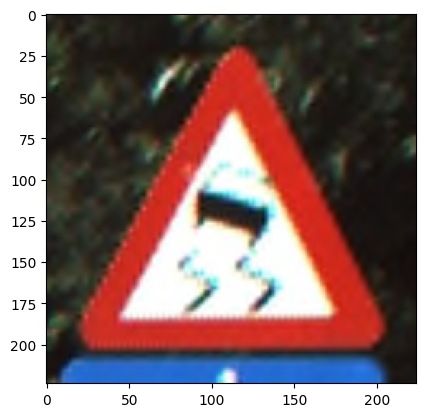

In [29]:
unique_cat = list(BelgiumTSC_full.ClassId.unique())
class_id = unique_cat[class_num]
index = 4
df_temp = BelgiumTSC_full[BelgiumTSC_full['ClassId'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'file_name']
class_num+=1
display(df_temp.loc[index, 'sign_name'])
img = Image.open(os.path.join(dataset_path, img_name))
transform = transforms.Compose([transforms.Resize((224,224))])   
img = transform(img)
fig, a = plt.subplots(1,1)
a.imshow(img)

In [30]:
# Распределение частоты появления знаков в RTSD_train
RTSD_train_distribution = pd.DataFrame(RTSD_train['sign'].value_counts().sort_index())
# Распределение частоты появления знаков в GTSRB_full
GTSRB_full_distribution = pd.DataFrame(GTSRB_full['sign'].value_counts())
# Распределение частоты появления знаков в GTSRB_full
BelgiumTSC_full_distribution = pd.DataFrame(BelgiumTSC_full['sign'].value_counts())

# Результирующий датасет
counts_signs_all = pd.merge(RTSD_train_distribution, GTSRB_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, BelgiumTSC_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all.rename(columns={'sign_x': 'RTSD_train', 'sign_y': 'GTSRB_full', 'sign': 'BelgiumTSC_full'},inplace=True)

# Заменим пропуски нулями
counts_signs_all = counts_signs_all.fillna(0)
counts_signs_all['GTSRB_full'] = counts_signs_all['GTSRB_full'].astype(int)
counts_signs_all['BelgiumTSC_full'] = counts_signs_all['BelgiumTSC_full'].astype(int)
counts_signs_all

,RTSD_train,GTSRB_full,BelgiumTSC_full
1_1,205,0,21
1_10,18,0,0
1_11,350,450,27
1_11_1,441,270,21
1_12,171,0,24
...,...,...,...
8_5_2,78,0,0
8_5_4,83,0,0
8_6_2,23,0,0
8_6_4,37,0,0


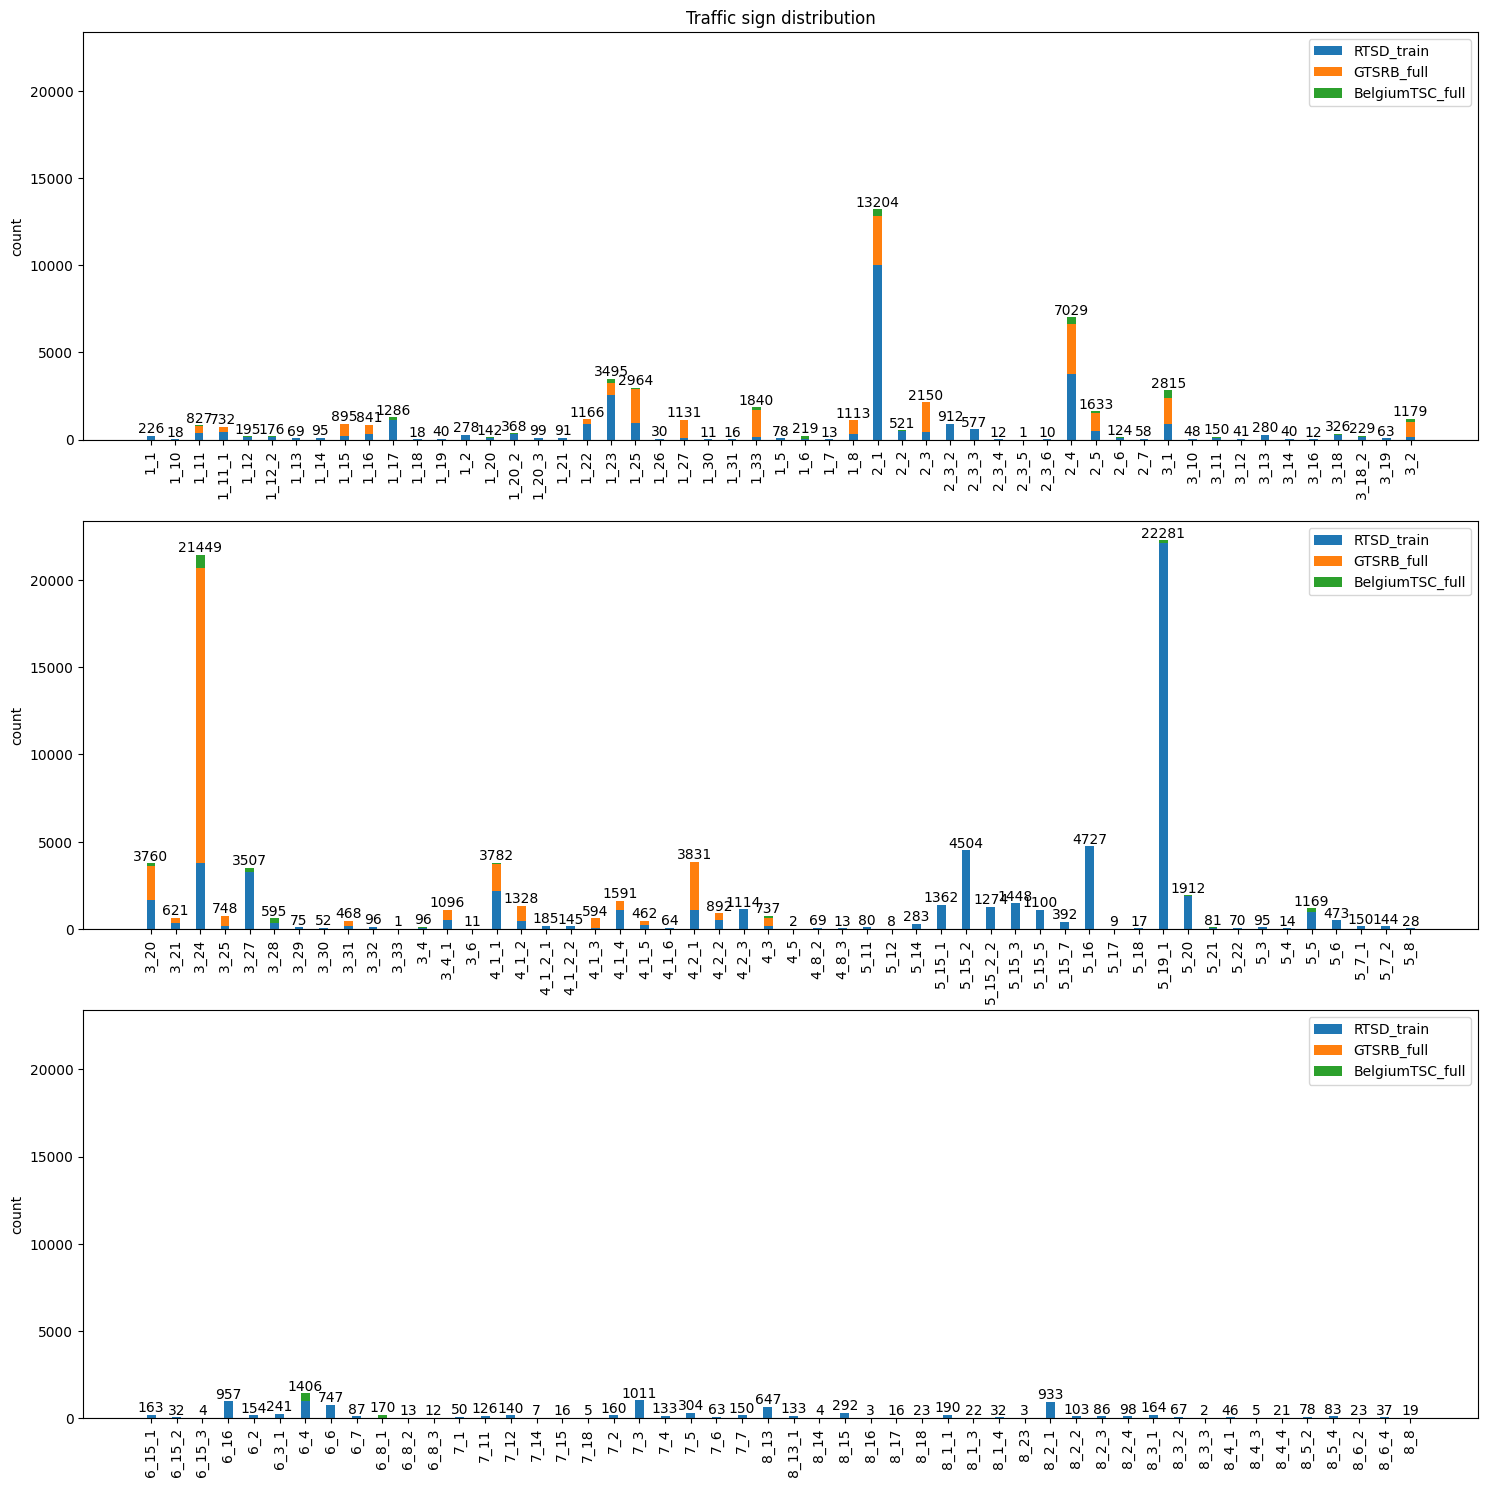

In [31]:
x1 = counts_signs_all.index[:53]   # the x locations for the groups
y1_1 = counts_signs_all.RTSD_train[:53]
y1_2 = counts_signs_all.GTSRB_full[:53]
y1_3 = counts_signs_all.BelgiumTSC_full[:53]


x2 = counts_signs_all.index[53:105]   # the x locations for the groups
y2_1 = counts_signs_all.RTSD_train[53:105]
y2_2 = counts_signs_all.GTSRB_full[53:105]
y2_3 = counts_signs_all.BelgiumTSC_full[53:105]

x3 = counts_signs_all.index[105:]   # the x locations for the groups
y3_1 = counts_signs_all.RTSD_train[105:]
y3_2 = counts_signs_all.GTSRB_full[105:]
y3_3 = counts_signs_all.BelgiumTSC_full[105:]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()

p1_1 = ax1.bar(x1 , y1_1, width, label='RTSD_train')
p1_2 = ax1.bar(x1 , y1_2, width, bottom=y1_1, label='GTSRB_full')
p1_3 = ax1.bar(x1 , y1_3, width, bottom=y1_1+y1_2, label='BelgiumTSC_full')
ax1.axhline(0, color='grey', linewidth=0.8)
ax1.set_ylabel('count')
ax1.set_title('Traffic sign distribution')
ax1.set_xticks(x1, x1, rotation=90)
ax1.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax1.bar_label(p1_1, label_type='center')
#ax1.bar_label(p1_2, label_type='center')
ax1.bar_label(p1_3)

p2_1 = ax2.bar(x2 , y2_1, width, label='RTSD_train')
p2_2 = ax2.bar(x2 , y2_2, width, bottom=y2_1, label='GTSRB_full')
p2_3 = ax2.bar(x2 , y2_3, width, bottom=y2_1+y2_2, label='BelgiumTSC_full')
ax2.axhline(0, color='grey', linewidth=0.8)
ax2.set_ylabel('count')
ax2.set_xticks(x2, x2, rotation=90)
ax2.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax2.bar_label(p2_1, label_type='center')
#ax2.bar_label(p2_2, label_type='center')
ax2.bar_label(p2_3)

p3_1 = ax3.bar(x3, y3_1, width, label='RTSD_train')
p3_2 = ax3.bar(x3, y3_2, width, bottom=y3_1, label='GTSRB_full')
p3_3 = ax3.bar(x3 , y3_3, width, bottom=y3_1+y3_2, label='BelgiumTSC_full')
ax3.axhline(0, color='grey', linewidth=0.8)
ax3.set_ylabel('count')
ax3.set_xticks(x3, x3, rotation=90)
ax3.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax3.bar_label(p3_1, label_type='center')
#ax3.bar_label(p3_2, label_type='center')
ax3.bar_label(p3_3)

fig.set_size_inches(18,18)
plt.show()

### Датасет Chinese Traffic Signs

In [33]:
# Мой маппинг категорий ChineseTS на Российские знаки (которые есть в RTSD)
ChineseTS_to_RTSD_labels = {}

ChineseTS_to_RTSD_labels[0] = '3_24'                      
ChineseTS_to_RTSD_labels[1] = '3_24'
ChineseTS_to_RTSD_labels[2] = '3_24'
ChineseTS_to_RTSD_labels[3] = '3_24'
ChineseTS_to_RTSD_labels[4] = '3_24'
ChineseTS_to_RTSD_labels[5] = '3_24'
ChineseTS_to_RTSD_labels[6] = '3_24'
ChineseTS_to_RTSD_labels[7] = '3_24'
ChineseTS_to_RTSD_labels[11] = '3_18_2'
ChineseTS_to_RTSD_labels[13] = '3_18'
ChineseTS_to_RTSD_labels[15] = '3_19'
ChineseTS_to_RTSD_labels[18] = '3_25'
ChineseTS_to_RTSD_labels[19] = '3_25'
ChineseTS_to_RTSD_labels[20] = '4_1_4'
ChineseTS_to_RTSD_labels[21] = '4_1_1'
ChineseTS_to_RTSD_labels[22] = '4_1_3'
ChineseTS_to_RTSD_labels[23] = '4_1_6'
ChineseTS_to_RTSD_labels[24] = '4_1_2'
ChineseTS_to_RTSD_labels[25] = '4_2_2'
ChineseTS_to_RTSD_labels[26] = '4_2_1'
ChineseTS_to_RTSD_labels[27] = '4_3'
ChineseTS_to_RTSD_labels[28] = '5_3'
ChineseTS_to_RTSD_labels[31] = '6_3_1'
ChineseTS_to_RTSD_labels[33] = '1_8'
ChineseTS_to_RTSD_labels[34] = '1_33'
ChineseTS_to_RTSD_labels[35] = '1_22'
ChineseTS_to_RTSD_labels[37] = '1_23'
ChineseTS_to_RTSD_labels[43] = '2_3_2'
ChineseTS_to_RTSD_labels[44] = '2_3_3'
ChineseTS_to_RTSD_labels[47] = '1_2'
ChineseTS_to_RTSD_labels[48] = '1_25'
ChineseTS_to_RTSD_labels[50] = '1_1'
ChineseTS_to_RTSD_labels[54] = '3_27'
ChineseTS_to_RTSD_labels[55] = '3_1'


#with open(os.path.join(dataset_path, 'ChineseTS_to_RTSD_labels.json'), 'w') as f:
#    json.dump(ChineseTS_to_RTSD_labels, f)#ensure_ascii=False, indent=4)
#f.close()

ChineseTS_to_RTSD_labels

{0: '3_24',
 1: '3_24',
 2: '3_24',
 3: '3_24',
 4: '3_24',
 5: '3_24',
 6: '3_24',
 7: '3_24',
 11: '3_18_2',
 13: '3_18',
 15: '3_19',
 18: '3_25',
 19: '3_25',
 20: '4_1_4',
 21: '4_1_1',
 22: '4_1_3',
 23: '4_1_6',
 24: '4_1_2',
 25: '4_2_2',
 26: '4_2_1',
 27: '4_3',
 28: '5_3',
 31: '6_3_1',
 33: '1_8',
 34: '1_33',
 35: '1_22',
 37: '1_23',
 43: '2_3_2',
 44: '2_3_3',
 47: '1_2',
 48: '1_25',
 50: '1_1',
 54: '3_27',
 55: '3_1'}

Примечания:
- Знак категории 28 - Дорога для автомобилей (не похоже)            5_3;
- Знак категории 43 - Примыкание второстепенной дороги (справа)+-   2_3_2;
- Знак категории 44 - Примыкание второстепенной дороги (слева) +-   2_3_3;
- Знак категории 47 - Железнодорожный переезд без шлагбаума +-      1_2;
- Знак категории 50 - Железнодорожный переезд со шлагбаумом +-       1_1.

In [369]:
# Выборка в датасете одна
ChineseTS = pd.read_csv(os.path.join(dataset_path, 'ChineseTS', 'annotations.csv'))
for i in range(len(ChineseTS)):
    ChineseTS.loc[i, 'file_name'] = 'images/' + ChineseTS.loc[i, 'file_name']
ChineseTS.insert(1, 'source', 'ChineseTS')

# Приведение датасеты к виду скорректированного RTSD
# Корректировка пути к изображению
ChineseTS['file_name'] = ChineseTS['file_name'].apply(lambda x: 'ChineseTS/' + x)

# Столбец bbox
ChineseTS.insert(2, 'bbox', '')
for i in range(len(ChineseTS)):
    x1 = int(ChineseTS.loc[i, 'x1'])
    y1 = int(ChineseTS.loc[i, 'y1'])
    x2 = int(ChineseTS.loc[i, 'x2'])
    y2 = int(ChineseTS.loc[i, 'y2'])
    bbox = [x1, y1, x2, y2]
    ChineseTS['bbox'].iloc[i] = bbox.copy()

del ChineseTS['x1']
del ChineseTS['y1']
del ChineseTS['x2']
del ChineseTS['y2']

# Добавим российские лейблы и категории в датасет
# Знаки, которые не соотносятся с RTSD удаляются
ChineseTS = ChineseTS.merge(pd.DataFrame([ChineseTS_to_RTSD_labels]).T, left_on='category', right_index=True)
ChineseTS.rename(columns={'category':'ClassId', 0: 'sign'}, inplace=True)
# Добавим классы знаков RTSD
ChineseTS = ChineseTS.merge(pd.DataFrame([label_map]).T, left_on='sign', right_index=True)
ChineseTS.rename(columns={0:'category_id'}, inplace=True)
# Добавим столбец с наименованием знака
ChineseTS = ChineseTS.merge(pd.DataFrame([labels_names_map]).T, left_on='sign', right_index=True)
ChineseTS.rename(columns={0:'sign_name'}, inplace=True)
ChineseTS.reset_index(inplace=True)
del ChineseTS['index']
GTSRB_full = GTSRB_full[['file_name', 'source', 'width', 'height', 'bbox', 'ClassId', 'category_id', 'sign', 'sign_name']]
#del ChineseTS['category']
ChineseTS

C:\Users\User\AppData\Local\Temp\ipykernel_1688\183855533.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ChineseTS['bbox'].iloc[i] = bbox.copy()


,file_name,source,bbox,width,height,ClassId,sign,category_id,sign_name
0,ChineseTS/images/000_0001.png,ChineseTS,"[19, 7, 120, 117]",134,128,0,3_24,4,Ограничение максимальной скорости
1,ChineseTS/images/000_0002.png,ChineseTS,"[23, 12, 149, 138]",165,151,0,3_24,4,Ограничение максимальной скорости
2,ChineseTS/images/000_0003.png,ChineseTS,"[22, 14, 116, 105]",128,122,0,3_24,4,Ограничение максимальной скорости
3,ChineseTS/images/000_0010.png,ChineseTS,"[14, 8, 67, 63]",80,73,0,3_24,4,Ограничение максимальной скорости
4,ChineseTS/images/000_0011.png,ChineseTS,"[36, 15, 155, 157]",186,174,0,3_24,4,Ограничение максимальной скорости
...,...,...,...,...,...,...,...,...,...
4359,ChineseTS/images/055_1_0025_1_j.png,ChineseTS,"[30, 25, 66, 71]",88,93,55,3_1,69,Въезд запрещён
4360,ChineseTS/images/055_1_0026_1_j.png,ChineseTS,"[21, 23, 74, 75]",93,97,55,3_1,69,Въезд запрещён
4361,ChineseTS/images/055_1_0027_1_j.png,ChineseTS,"[25, 20, 74, 69]",104,99,55,3_1,69,Въезд запрещён
4362,ChineseTS/images/055_1_0028_1_j.png,ChineseTS,"[24, 19, 110, 103]",141,134,55,3_1,69,Въезд запрещён


In [370]:
# Перебор категорий и проверка что они соответствуют
class_num = 0

'Ограничение максимальной скорости'

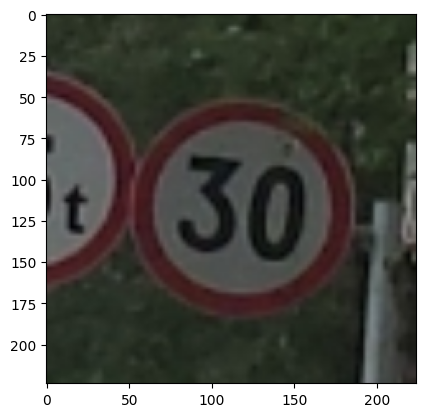

In [373]:
unique_cat = list(ChineseTS.ClassId.unique())
class_id = unique_cat[class_num]
index = 0
df_temp = ChineseTS[ChineseTS['ClassId'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'file_name']
class_num+=1
display(df_temp.loc[index, 'sign_name'])
img = Image.open(os.path.join(dataset_path, img_name))
transform = transforms.Compose([transforms.Resize((224,224))])   
img = transform(img)
fig, a = plt.subplots(1,1)
a.imshow(img)

In [374]:
# Распределение частоты появления знаков в RTSD_train
RTSD_train_distribution = pd.DataFrame(RTSD_train['sign'].value_counts().sort_index())
RTSD_train_distribution.rename(columns={'sign': 'RTSD_train'},inplace=True)
# Распределение частоты появления знаков в GTSRB_full
GTSRB_full_distribution = pd.DataFrame(GTSRB_full['sign'].value_counts())
GTSRB_full_distribution.rename(columns={'sign': 'GTSRB_full'},inplace=True)
# Распределение частоты появления знаков в GTSRB_full
BelgiumTSC_full_distribution = pd.DataFrame(BelgiumTSC_full['sign'].value_counts())
BelgiumTSC_full_distribution.rename(columns={'sign': 'BelgiumTSC_full'},inplace=True)
# Распределение частоты появления знаков в ChineseTS
ChineseTS_distribution = pd.DataFrame(ChineseTS['sign'].value_counts())
ChineseTS_distribution.rename(columns={'sign': 'ChineseTS'},inplace=True)
# Результирующий датасет
counts_signs_all = pd.merge(RTSD_train_distribution, GTSRB_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, BelgiumTSC_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, ChineseTS_distribution, left_index=True, right_index=True, how='left')

# Заменим пропуски нулями
counts_signs_all = counts_signs_all.fillna(0)
counts_signs_all['GTSRB_full'] = counts_signs_all['GTSRB_full'].astype(int)
counts_signs_all['BelgiumTSC_full'] = counts_signs_all['BelgiumTSC_full'].astype(int)
counts_signs_all['ChineseTS'] = counts_signs_all['ChineseTS'].astype(int)
counts_signs_all

,RTSD_train,GTSRB_full,BelgiumTSC_full,ChineseTS
1_1,205,0,21,76
1_10,18,0,0,0
1_11,350,450,27,0
1_11_1,441,270,21,0
1_12,171,0,24,0
...,...,...,...,...
8_5_2,78,0,0,0
8_5_4,83,0,0,0
8_6_2,23,0,0,0
8_6_4,37,0,0,0


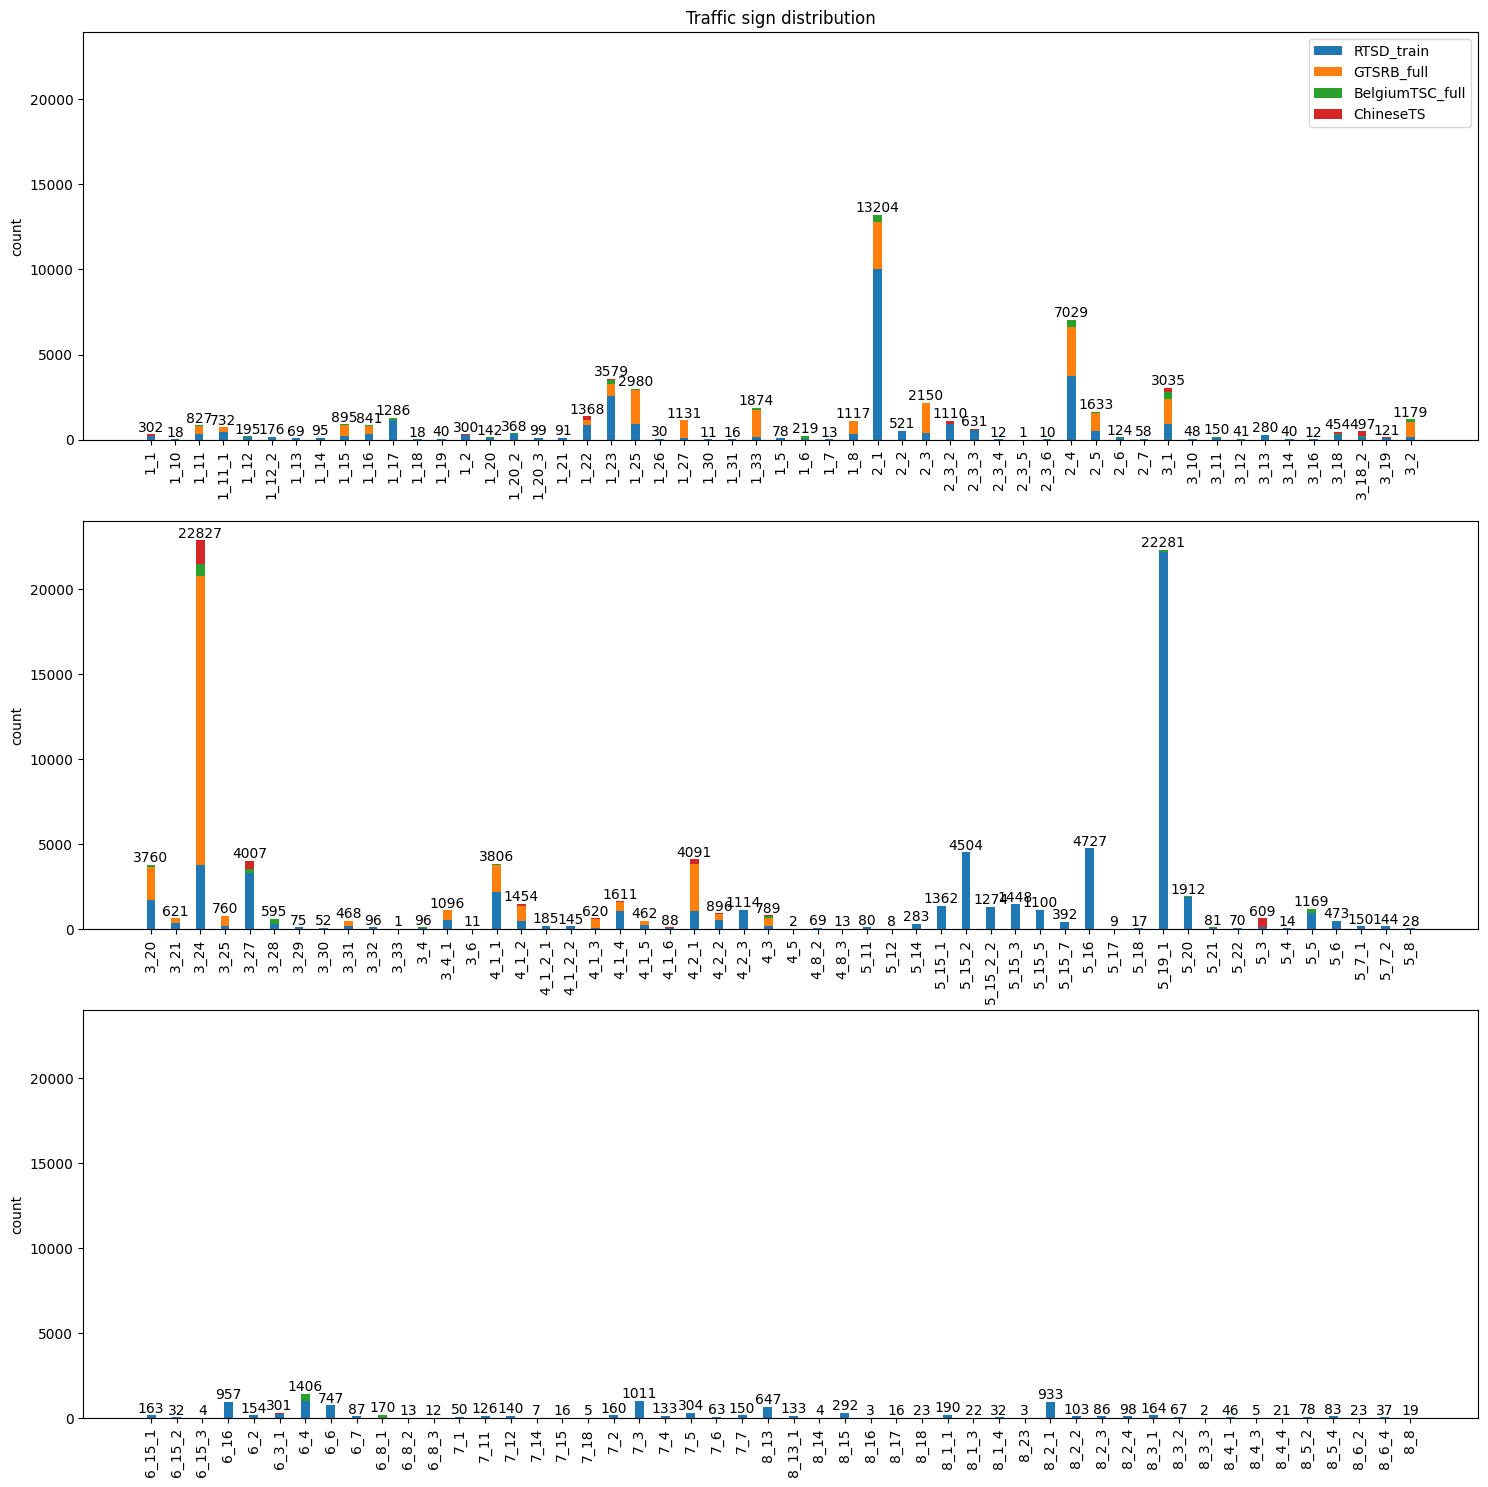

In [375]:
x1 = counts_signs_all.index[:53]   # the x locations for the groups
y1_1 = counts_signs_all.RTSD_train[:53]
y1_2 = counts_signs_all.GTSRB_full[:53]
y1_3 = counts_signs_all.BelgiumTSC_full[:53]
y1_4 = counts_signs_all.ChineseTS[:53]

x2 = counts_signs_all.index[53:105]   # the x locations for the groups
y2_1 = counts_signs_all.RTSD_train[53:105]
y2_2 = counts_signs_all.GTSRB_full[53:105]
y2_3 = counts_signs_all.BelgiumTSC_full[53:105]
y2_4 = counts_signs_all.ChineseTS[53:105]

x3 = counts_signs_all.index[105:]   # the x locations for the groups
y3_1 = counts_signs_all.RTSD_train[105:]
y3_2 = counts_signs_all.GTSRB_full[105:]
y3_3 = counts_signs_all.BelgiumTSC_full[105:]
y3_4 = counts_signs_all.ChineseTS[105:]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()

p1_1 = ax1.bar(x1 , y1_1, width, label='RTSD_train')
p1_2 = ax1.bar(x1 , y1_2, width, bottom=y1_1, label='GTSRB_full')
p1_3 = ax1.bar(x1 , y1_3, width, bottom=y1_1+y1_2, label='BelgiumTSC_full')
p1_4 = ax1.bar(x1 , y1_4, width, bottom=y1_1+y1_2+y1_3, label='ChineseTS')
ax1.axhline(0, color='grey', linewidth=0.8)
ax1.set_ylabel('count')
ax1.set_title('Traffic sign distribution')
ax1.set_xticks(x1, x1, rotation=90)
ax1.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax1.bar_label(p1_1, label_type='center')
#ax1.bar_label(p1_2, label_type='center')
ax1.bar_label(p1_4)

p2_1 = ax2.bar(x2 , y2_1, width, label='RTSD_train')
p2_2 = ax2.bar(x2 , y2_2, width, bottom=y2_1, label='GTSRB_full')
p2_3 = ax2.bar(x2 , y2_3, width, bottom=y2_1+y2_2, label='BelgiumTSC_full')
p2_4 = ax2.bar(x2 , y2_4, width, bottom=y2_1+y2_2+y2_3, label='ChineseTS')
ax2.axhline(0, color='grey', linewidth=0.8)
ax2.set_ylabel('count')
ax2.set_xticks(x2, x2, rotation=90)
#ax2.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax2.bar_label(p2_1, label_type='center')
#ax2.bar_label(p2_2, label_type='center')
ax2.bar_label(p2_4)

p3_1 = ax3.bar(x3, y3_1, width, label='RTSD_train')
p3_2 = ax3.bar(x3, y3_2, width, bottom=y3_1, label='GTSRB_full')
p3_3 = ax3.bar(x3 , y3_3, width, bottom=y3_1+y3_2, label='BelgiumTSC_full')
p3_4 = ax3.bar(x3 , y3_4, width, bottom=y3_1+y3_2+y3_3, label='ChineseTS')
ax3.axhline(0, color='grey', linewidth=0.8)
ax3.set_ylabel('count')
ax3.set_xticks(x3, x3, rotation=90)
#ax3.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax3.bar_label(p3_1, label_type='center')
#ax3.bar_label(p3_2, label_type='center')
ax3.bar_label(p3_4)

fig.set_size_inches(18,18)
plt.show()

Примечания:  
-     Датасет немецких знаков
- Знак категорий 0-5, 7, 8 Ограничение максимальной скорости                        '3_24'; - в RSTD их много, немного отличаются, выкидываем
- Знак категории 11 - Пересечение со второстепенной дорогой (немного отличается)    '2_3'; - слишком большой вес - выкидываем
-     Датасет бельгийских знаков
- Знак категории 24 - Ограничение по массе (немного не похоже)  '3_11' - выкидываем, отличается
-     Датасет китайских знаков
- Знак категории 28 - Дорога для автомобилей (не похоже)            5_3; - убираем, слишком большой вес
- Знак категории 43 - Примыкание второстепенной дороги (справа)+-   2_3_2; - убираем, сильно отличается
- Знак категории 44 - Примыкание второстепенной дороги (слева) +-   2_3_3; - убираем, сильно отличается
- Знак категории 47 - Железнодорожный переезд без шлагбаума +-      1_2; - убираем, сильно отличается
- Знак категории 50 - Железнодорожный переезд со шлагбаумом +-       1_1; - убираем, сильно отличается

### Формирование итогового датасета

In [401]:
# Загрузка background
background_anno_file = 'train_anno_reduced_background.json'
with open(os.path.join(dataset_path, background_anno_file), 'r') as read_file:
    RTSD_train_backgrnd_anno = json.load(read_file)
read_file.close()

RTSD_train_backgrnd = pd.DataFrame(RTSD_train_backgrnd_anno.get('annotations'))
df_backgrnd_images = pd.DataFrame(RTSD_train_backgrnd_anno.get('images'))
RTSD_train_backgrnd = RTSD_train_backgrnd.merge(df_backgrnd_images, left_on='image_id', right_on='id',)[['file_name', 'width', 'height', 'bbox','category_id']]

# Приведение bbox из формата COCO (x1, y1, w, h) к виду (x1, y1, x2, y2)
RTSD_train_backgrnd['bbox'] = RTSD_train_backgrnd['bbox'].apply (lambda x: [round(x[0]), round(x[1]), round(x[0]) + round(x[2]), round(x[1]) + round(x[3])])
# Добавим для визуалиции labels
RTSD_train_backgrnd['sign'] = '0'
# Добавим столбец с наименованием знака
RTSD_train_backgrnd['sign_name'] = 'Background'
# Добавим вспомогательную колонку с источником изображения (датасет)
RTSD_train_backgrnd.insert(1, 'source', 'RTSD_train')

# Конкатениция датафреймов + выбрасываем лишние знаки
RTSD_train_exp = RTSD_train_backgrnd.copy()
RTSD_train_copy = RTSD_train.copy()

GTSRB_full_copy = GTSRB_full.copy()
GTSRB_full_copy = GTSRB_full[(GTSRB_full.ClassId != 0) & (GTSRB_full.ClassId != 1) & (GTSRB_full.ClassId != 2) & (GTSRB_full.ClassId != 3) & (GTSRB_full.ClassId != 4) & (GTSRB_full.ClassId != 5) \
    & (GTSRB_full.ClassId != 7) & (GTSRB_full.ClassId != 8) & (GTSRB_full.ClassId != 11)].copy()

BelgiumTSC_full_copy = BelgiumTSC_full.copy()
BelgiumTSC_full_copy = BelgiumTSC_full[(BelgiumTSC_full.ClassId != 24)].copy()

ChineseTS_copy = ChineseTS[(ChineseTS.ClassId != 28) & (ChineseTS.ClassId != 43) & (ChineseTS.ClassId != 44) & (ChineseTS.ClassId != 47) & (ChineseTS.ClassId != 50)].copy()
ChineseTS[(ChineseTS.ClassId == 28) | (ChineseTS.ClassId == 43) | (ChineseTS.ClassId == 44) | (ChineseTS.ClassId == 47) | (ChineseTS.ClassId == 50)]

del GTSRB_full_copy['ClassId']
del BelgiumTSC_full_copy['ClassId']
del ChineseTS_copy['ClassId']

RTSD_train_exp = pd.concat((RTSD_train_exp, RTSD_train_copy))
RTSD_train_exp = pd.concat((RTSD_train_exp, GTSRB_full_copy))
RTSD_train_exp = pd.concat((RTSD_train_exp, BelgiumTSC_full_copy))
RTSD_train_exp = pd.concat((RTSD_train_exp, ChineseTS_copy))
RTSD_train_exp = RTSD_train_exp.sort_values('category_id')
RTSD_train_exp.reset_index(inplace=True)
del RTSD_train_exp['index']
RTSD_train_exp

,file_name,source,width,height,bbox,category_id,sign,sign_name
0,rtsd-frames/autosave01_02_2012_09_16_49.jpg,RTSD_train,1280,720,"[763, 307, 800, 372]",0,0,Background
1,rtsd-frames/autosave16_10_2012_07_15_14_0.jpg,RTSD_train,1280,720,"[968, 292, 992, 314]",0,0,Background
2,rtsd-frames/autosave16_10_2012_07_15_14_0.jpg,RTSD_train,1280,720,"[781, 234, 875, 320]",0,0,Background
3,rtsd-frames/autosave16_10_2012_07_15_14_1.jpg,RTSD_train,1280,720,"[763, 186, 790, 217]",0,0,Background
4,rtsd-frames/autosave16_10_2012_07_15_14_1.jpg,RTSD_train,1280,720,"[758, 186, 800, 236]",0,0,Background
...,...,...,...,...,...,...,...,...
133818,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg,RTSD_train,1280,720,"[767, 306, 806, 366]",154,7_14,Пункт транспортного контроля
133819,rtsd-frames/autosave24_10_2013_11_23_20_1.jpg,RTSD_train,1280,720,"[1143, 101, 1255, 252]",154,7_14,Пункт транспортного контроля
133820,rtsd-frames/autosave24_10_2013_11_29_00_0.jpg,RTSD_train,1280,720,"[762, 367, 798, 384]",155,8_23,Фотовидеофиксация
133821,rtsd-frames/autosave24_10_2013_11_29_00_1.jpg,RTSD_train,1280,720,"[878, 346, 934, 372]",155,8_23,Фотовидеофиксация


In [402]:
# Сохранение итогового датасета в pickle
RTSD_train_exp.to_pickle(os.path.join(dataset_path, 'RTSD_train_exp.pkl'))

Визуализация итогового датасета

In [ ]:
# Распределение частоты появления знаков в RTSD_train
RTSD_train_distribution = pd.DataFrame(RTSD_train['sign'].value_counts().sort_index())
RTSD_train_distribution.rename(columns={'sign': 'RTSD_train'},inplace=True)
# Распределение частоты появления знаков в GTSRB_full
GTSRB_full_distribution = pd.DataFrame(GTSRB_full['sign'].value_counts())
GTSRB_full_distribution.rename(columns={'sign': 'GTSRB_full'},inplace=True)
# Распределение частоты появления знаков в GTSRB_full
BelgiumTSC_full_distribution = pd.DataFrame(BelgiumTSC_full['sign'].value_counts())
BelgiumTSC_full_distribution.rename(columns={'sign': 'BelgiumTSC_full'},inplace=True)
# Распределение частоты появления знаков в ChineseTS
ChineseTS_distribution = pd.DataFrame(ChineseTS['sign'].value_counts())
ChineseTS_distribution.rename(columns={'sign': 'ChineseTS'},inplace=True)
# Результирующий датасет
counts_signs_all = pd.merge(RTSD_train_distribution, GTSRB_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, BelgiumTSC_full_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, ChineseTS_distribution, left_index=True, right_index=True, how='left')

# Заменим пропуски нулями
counts_signs_all = counts_signs_all.fillna(0)
counts_signs_all['GTSRB_full'] = counts_signs_all['GTSRB_full'].astype(int)
counts_signs_all['BelgiumTSC_full'] = counts_signs_all['BelgiumTSC_full'].astype(int)
counts_signs_all['ChineseTS'] = counts_signs_all['ChineseTS'].astype(int)
counts_signs_all

In [ ]:
x1 = counts_signs_all.index[:53]   # the x locations for the groups
y1_1 = counts_signs_all.RTSD_train[:53]
y1_2 = counts_signs_all.GTSRB_full[:53]
y1_3 = counts_signs_all.BelgiumTSC_full[:53]
y1_4 = counts_signs_all.ChineseTS[:53]

x2 = counts_signs_all.index[53:105]   # the x locations for the groups
y2_1 = counts_signs_all.RTSD_train[53:105]
y2_2 = counts_signs_all.GTSRB_full[53:105]
y2_3 = counts_signs_all.BelgiumTSC_full[53:105]
y2_4 = counts_signs_all.ChineseTS[53:105]

x3 = counts_signs_all.index[105:]   # the x locations for the groups
y3_1 = counts_signs_all.RTSD_train[105:]
y3_2 = counts_signs_all.GTSRB_full[105:]
y3_3 = counts_signs_all.BelgiumTSC_full[105:]
y3_4 = counts_signs_all.ChineseTS[105:]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()

p1_1 = ax1.bar(x1 , y1_1, width, label='RTSD_train')
p1_2 = ax1.bar(x1 , y1_2, width, bottom=y1_1, label='GTSRB_full')
p1_3 = ax1.bar(x1 , y1_3, width, bottom=y1_1+y1_2, label='BelgiumTSC_full')
p1_4 = ax1.bar(x1 , y1_4, width, bottom=y1_1+y1_2+y1_3, label='ChineseTS')
ax1.axhline(0, color='grey', linewidth=0.8)
ax1.set_ylabel('count')
ax1.set_title('Traffic sign distribution')
ax1.set_xticks(x1, x1, rotation=90)
ax1.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax1.bar_label(p1_1, label_type='center')
#ax1.bar_label(p1_2, label_type='center')
ax1.bar_label(p1_4)

p2_1 = ax2.bar(x2 , y2_1, width, label='RTSD_train')
p2_2 = ax2.bar(x2 , y2_2, width, bottom=y2_1, label='GTSRB_full')
p2_3 = ax2.bar(x2 , y2_3, width, bottom=y2_1+y2_2, label='BelgiumTSC_full')
p2_4 = ax2.bar(x2 , y2_4, width, bottom=y2_1+y2_2+y2_3, label='ChineseTS')
ax2.axhline(0, color='grey', linewidth=0.8)
ax2.set_ylabel('count')
ax2.set_xticks(x2, x2, rotation=90)
#ax2.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax2.bar_label(p2_1, label_type='center')
#ax2.bar_label(p2_2, label_type='center')
ax2.bar_label(p2_4)

p3_1 = ax3.bar(x3, y3_1, width, label='RTSD_train')
p3_2 = ax3.bar(x3, y3_2, width, bottom=y3_1, label='GTSRB_full')
p3_3 = ax3.bar(x3 , y3_3, width, bottom=y3_1+y3_2, label='BelgiumTSC_full')
p3_4 = ax3.bar(x3 , y3_4, width, bottom=y3_1+y3_2+y3_3, label='ChineseTS')
ax3.axhline(0, color='grey', linewidth=0.8)
ax3.set_ylabel('count')
ax3.set_xticks(x3, x3, rotation=90)
#ax3.legend()
# Label with label_type 'center' instead of the default 'edge'
#ax3.bar_label(p3_1, label_type='center')
#ax3.bar_label(p3_2, label_type='center')
ax3.bar_label(p3_4)

fig.set_size_inches(18,18)
plt.show()

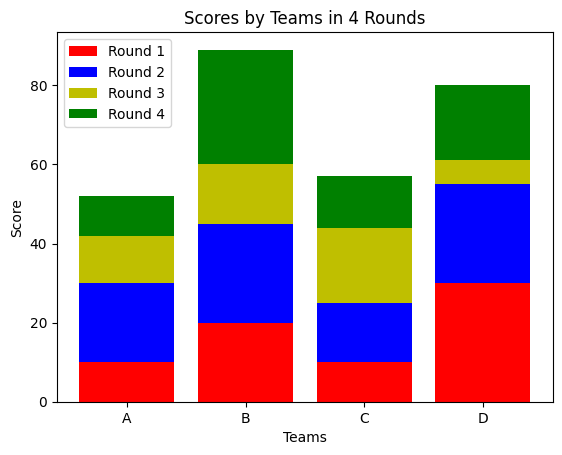

In [380]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = ['A', 'B', 'C', 'D']
y1 = np.array([10, 20, 10, 30])
y2 = np.array([20, 25, 15, 25])
y3 = np.array([12, 15, 19, 6])
y4 = np.array([10, 29, 13, 19])
 
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Teams")
plt.ylabel("Score")
plt.legend(["Round 1", "Round 2", "Round 3", "Round 4"])
plt.title("Scores by Teams in 4 Rounds")
plt.show()